In [1]:
import pandas as pd
import numpy as np
import yaml
import pickle
from sklearn import tree
import shap
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
shap.initjs()
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import catboost
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import math
import warnings
warnings.filterwarnings('ignore')

In [2]:
m = pd.read_parquet('master.parquet')

In [3]:
m

,SALES_PER_COUNTRY_PREV_YEAR,SALES_PER_CLIENT_PREV_YEAR,LAUNCH_YEAR,N_REFRIGERANT,VOLTAGE,ROBUSTNESS,POWER,EFFICIENCY,N_BOM,NOISE,...,LEGACY_REFRIGERANT_No,LEGACY_REFRIGERANT_Yes (A2L & A3),LEGACY_REFRIGERANT_Yes (A2L),LEGACY_REFRIGERANT_Yes (A3),LEGACY_REFRIGERANT_yes (A2L),TEMPERATURE_High Temperature,EXCLUSIVE_TECH_no,EASY_INSTALL_1 (T-Connect),GM%,SAMPLE_WEIGHTS
0,5428857.02,749276.04,2016,2,3,1,254,2.17,16,50,...,0,0,1,0,0,1,1,0,41.260695,0
1,5428857.02,749276.04,2016,2,4,1,388,1.95,12,45,...,1,0,0,0,0,1,1,0,59.675210,0
2,456627.66,158697.83,2015,4,4,3,1325,2.31,39,64,...,0,0,1,0,0,1,1,1,55.167836,0
3,456627.66,158697.83,2012,4,3,2,894,2.08,14,57,...,0,1,0,0,0,1,1,0,34.823203,0
4,718880.31,95548.92,2010,4,2,4,6808,2.16,16,81,...,0,0,1,0,0,1,1,0,38.062677,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187331,2913878.64,1815290.95,2010,4,2,4,6808,2.16,16,81,...,0,0,1,0,0,1,1,0,-5.399649,0
187332,3658722.92,452451.45,2016,1,3,1,141,1.91,6,43,...,1,0,0,0,0,1,1,0,65.642504,1
187333,9929931.48,1354972.44,2012,2,3,1,412,2.18,24,52,...,0,0,1,0,0,1,1,0,27.443947,1
187334,677348.49,255856.94,2014,4,4,3,1881,2.10,32,61,...,0,0,0,0,1,1,1,1,13.921543,0


In [4]:
m.isnull().sum().count()

131

In [5]:
## Splitting the dataset ##
X = m.drop(['GM%', 'SAMPLE_WEIGHTS'], axis=1)
y = m['GM%'].copy()
weights = m['SAMPLE_WEIGHTS'].copy()

In [6]:
## Fitting the Random Forest Regressor Model with hypertuned parameters ##
print('Fitting the model....')
rf1 = RandomForestRegressor(ccp_alpha=0.01, max_depth=14, min_samples_leaf=2,min_samples_split=5, n_estimators=10)
rf1.fit(X, y, sample_weight = weights)
print('done fitting !!!')

Fitting the model....
done fitting !!!


In [7]:
## Evaluating Model performance with Hypertuned params for Random Forest Regressor##
## Getting the Global Scores, Score on highest-weighted observations & Highest-weighted observations with GM% absolute error within 2%
## 5%, 10% threshold ##
print(f"Global Score (R2): {rf1.score(X, y)}")
t2 = pd.concat((y.rename('true'), pd.Series(rf1.predict(X), name='predict')), axis=1)
mask = weights == weights.max()
print(f"Score on highest-weighted observations: {rf1.score(X[mask], y[mask])}")
for thresh in [2, 5, 10]:
    close = (t2[mask]['true'] - t2[mask]['predict']).abs() < thresh
    print(f"Highest-weighted observations with GM% absolute error within {thresh}%: {(close.sum() / len(close) * 100).round(2)} %")

Global Score (R2): 0.7626249776224934
Score on highest-weighted observations: 0.9117067386264571
Highest-weighted observations with GM% absolute error within 2%: 43.17 %
Highest-weighted observations with GM% absolute error within 5%: 75.99 %
Highest-weighted observations with GM% absolute error within 10%: 93.23 %


In [8]:
## SHAP Value for Random Forest Regressor Model ##
print("Calculating SHAP values (may take a while...)")
explainer = shap.TreeExplainer(rf1)  # Create object that can calculate shap values
shap_values = explainer(X)
print('done calculating the shap values')

Calculating SHAP values (may take a while...)
done calculating the shap values


In [9]:
shap_values

.values =
array([[-8.76925624e-01, -1.14177380e+00,  2.64310103e+00, ...,
        -1.61773558e-02, -7.73219947e-04,  9.41997161e-03],
       [-3.04253792e-01, -6.73772973e-01,  3.37029469e+00, ...,
        -1.48374289e-02, -5.00432474e-04,  3.36567496e-02],
       [ 2.81745797e-01, -1.02037252e-01,  3.28494125e+00, ...,
         2.82701548e-03, -5.62981592e-04, -3.38187711e-02],
       ...,
       [ 4.09452209e-02, -3.54840785e+00, -8.09943969e-01, ...,
         3.28351014e-02, -1.53511503e-02,  1.28381249e-02],
       [ 2.21133143e-01, -5.00538882e-02,  1.48557800e+00, ...,
         1.95769141e-03, -1.14451536e-03, -1.41682419e-02],
       [-5.97355301e-01, -4.26650601e+00,  2.64210661e+00, ...,
         2.56857682e-03, -1.09377810e-03, -2.93294953e-02]])

.base_values =
array([[39.40981312],
       [39.40981312],
       [39.40981312],
       ...,
       [39.40981312],
       [39.40981312],
       [39.40981312]])

.data =
array([[5.42885702e+06, 7.49276040e+05, 2.01600000e+03, ...,
  

In [10]:
explainer.expected_value

array([39.40981312])

In [11]:
import pickle
shap_out = open("shapX.pickle", "wb")
pickle.dump(shap_values, shap_out)
shap_out.close()

In [12]:
## Shap Import ##
shap_imp = open("shapX.pickle", "rb")
shaps = pickle.load(shap_imp)

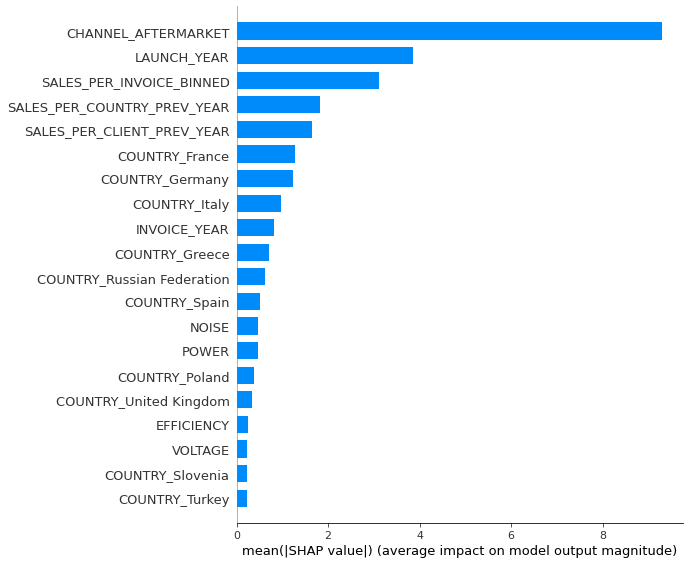

In [13]:
## Shapely Plot ##
shap.summary_plot(shap_values, X, plot_type="bar")

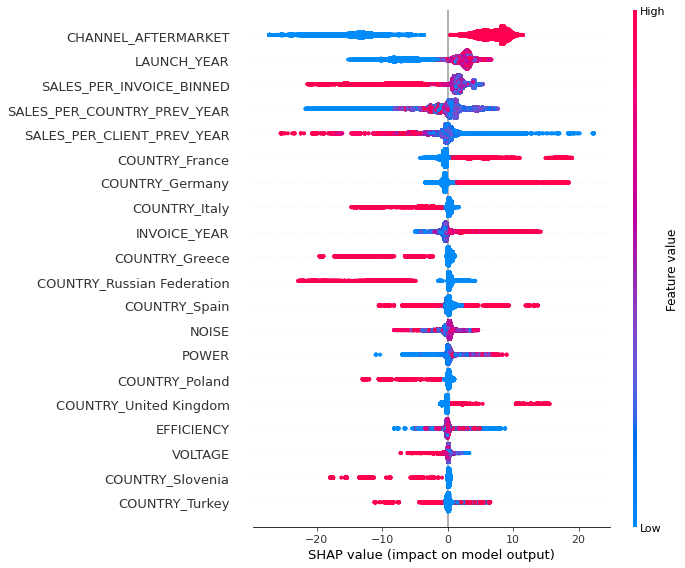

In [14]:
## Below shapely plot shows the the most important features from top to bottom and their contribution in terms of shapely values
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(shap_values, X)
f.savefig("/summary_plot1.png", bbox_inches='tight', dpi=600)

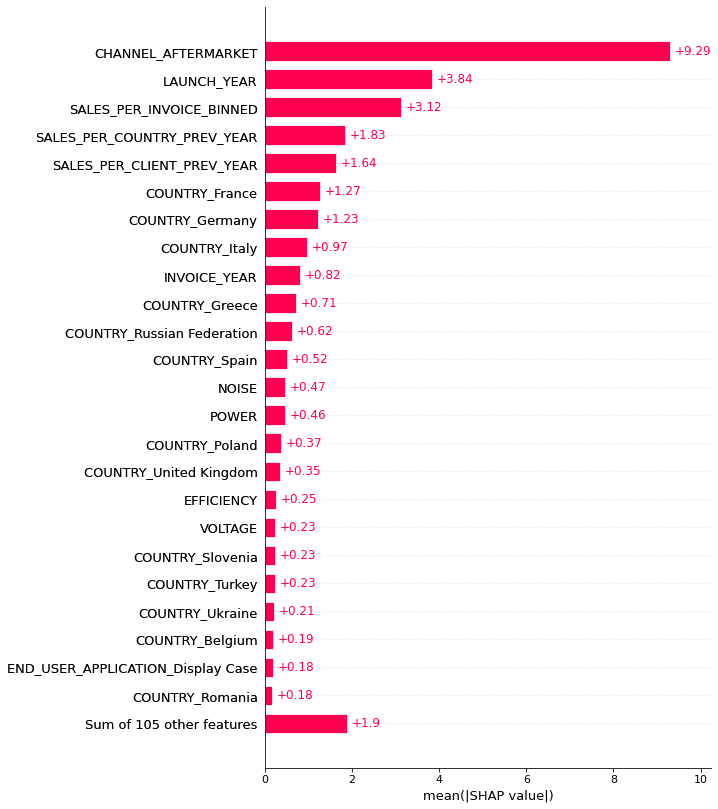

In [15]:
## Below shapely bar plot shows the the most important features from top to bottom and their contribution in terms of shapely values

shap.plots.bar(shap_values,max_display=25)

In [17]:
#shap.plots.waterfall(shap_values[0], max_display=25)

In [18]:
## Shap Value export ##
mode = 'regular'
# load shap values
shap_imp = open("shapX.pickle", "rb")
shaps = pickle.load(shap_imp)
# load master and cleaned database
X = pd.read_parquet('master.parquet')
cleaned = pd.read_parquet('cleaned_database.parquet')
aggregation_mode = "item|country|channel"
max_bins = 5
groupby_geographies = False
geographies = {'ESP_PRT_ITA':['Spain', 'Portugal', 'Ita'], 'DEU_AUT_CHE':['Germany', 'Austria', 'Switzerland'],'DNK_NOR_SWE_FIN':
              ['Denmark', 'Norway', 'Sweden', 'Finland'],'FRA_BEL_NLD':['France', 'Belgium', 'Netherlands'],'GBR':['United Kingdom', 'Ireland'],
              'POL_CZE_SVK_HUN_ROU_GRC_CYP':['Poland', 'Czech Republic', 'Slovakia', 'Hungary', 'Romania', 'Greece', 'Cyprus'],
              'SRB_SVN_HRV_ALB':['Serbia', 'Slovenia', 'Croatia', 'Albania']}
feats = ['COUNTRY','SALES_PER_COUNTRY_PREV_YEAR','CHANNEL','SALES_PER_CLIENT_PREV_YEAR','LAUNCH_YEAR','END_USER_APPLICATION','FAMILY',
        'REFRIGERANT_TYPE','N_REFRIGERANT','LEGACY_REFRIGERANT','VOLTAGE','ROBUSTNESS','POWER','TEMPERATURE','EFFICIENCY','EXCLUSIVE_TECH',
        'EASY_INSTALL','N_BOM','NOISE','SALES_PER_INVOICE_BINNED','INVOICE_YEAR']
output_columns_sorted = ['COMMERCIAL_NAME','COUNTRY','CHANNEL','LAUNCH_YEAR_SHAP','END_USER_APPLICATION_SHAP','FAMILY_SHAP',
                        'REFRIGERANT_TYPE_SHAP','N_REFRIGERANT_SHAP','LEGACY_REFRIGERANT_SHAP','VOLTAGE_SHAP','ROBUSTNESS_SHAP',
                        'POWER_SHAP','TEMPERATURE_SHAP','EFFICIENCY_SHAP','EXCLUSIVE_TECH_SHAP','EASY_INSTALL_SHAP','N_BOM_SHAP',
                        'NOISE_SHAP','COUNTRY_SHAP','CHANNEL_SHAP','SALES_PER_CLIENT_PREV_YEAR_SHAP','SALES_PER_COUNTRY_PREV_YEAR_SHAP',
                        'SALES_PER_INVOICE_BINNED_SHAP','INVOICE_YEAR_SHAP']


if aggregation_mode == "item|country|channel":
    """
    Shap values aggregated on the triplet item, country and channel.
    """
    # aggregate shap values on triplet 'COMMERCIAL_NAME', 'COUNTRY', 'CHANNEL'
    shap_df = pd.DataFrame(shaps.values, columns=X.drop(['GM%', 'SAMPLE_WEIGHTS'], axis=1).columns)
    shap_df = pd.concat([cleaned[['COMMERCIAL_NAME', 'COUNTRY', 'CHANNEL']], shap_df, X['GM%']], axis=1)
    perc_50 = shap_df.groupby(['COMMERCIAL_NAME', 'COUNTRY', 'CHANNEL'])['GM%'].transform(lambda x: x.quantile(0.5))
    high_margin_shap_vals = shap_df[X['SAMPLE_WEIGHTS'].astype(bool)].drop('GM%', axis=1)
    if groupby_geographies:
        # add geographical areas
        high_margin_shap_vals['GEOGRAPHY'] = high_margin_shap_vals['COUNTRY']
        for geo, countries in geographies.items():
            high_margin_shap_vals.loc[high_margin_shap_vals['COUNTRY'].isin(countries), 'GEOGRAPHY'] = geo
        # group shap values per item | geographical area | channel
        out = high_margin_shap_vals.drop('COUNTRY', axis=1).groupby(['COMMERCIAL_NAME', 'GEOGRAPHY', 'CHANNEL']).mean()
        # expand into triplets of the kind item | country | channel
        tmp = high_margin_shap_vals.set_index(['COMMERCIAL_NAME', 'COUNTRY', 'CHANNEL'])
        tmp = tmp[~tmp.index.duplicated(keep='first')]  # get the right index
        tmp = tmp.reset_index().set_index(['COMMERCIAL_NAME', 'GEOGRAPHY', 'CHANNEL'])  # reset index
        tmp = pd.merge(tmp['COUNTRY'], out, how='left', left_index=True, right_index=True)  # merge
        out = tmp.reset_index().drop('GEOGRAPHY', axis=1).set_index(['COMMERCIAL_NAME', 'COUNTRY', 'CHANNEL'])
    else:
        out = high_margin_shap_vals.groupby(['COMMERCIAL_NAME', 'COUNTRY', 'CHANNEL']).mean()
    assert1 = out.sum(axis=1)  # delta prediction from aggregated (row-wise) shaps
    
        # aggregate shap values on original categorical features
    for f in feats:
        try:
            is_object = X[f].dtype == 'O'
        except KeyError:
            is_object = cleaned[f].dtype == 'O'
        if is_object:
            to_aggregate = [c for c in out.columns if c.startswith(f + '_')]
            out[f + '_SHAP'] = out[to_aggregate].sum(axis=1)
        else:
            out[f + '_SHAP'] = out[f]
    out = out[[c for c in out.columns if c.endswith('_SHAP')]]
    assert2 = out.sum(axis=1)   # delta prediction from partially aggregated (column-wise) shaps
    pd.testing.assert_series_equal(assert1, assert2)  # predictions per triplet must be equal
    
    # sort columns
    out = out.reset_index()
    out = out[output_columns_sorted]
elif aggregation_mode == 'global':
    """
    Univariate Shap values. 
    For each value of any feature (binned value in case of continuous features), calculate the mean shap value
    from all the transactions. 
    """
    shap_df = pd.DataFrame(shaps.values, columns=X.drop(['GM%', 'SAMPLE_WEIGHTS'], axis=1).columns)

    # identify categorical and continuous features
    cats = []
    conts = []

    for c in feats:
        # count as many shap columns there are for a feature of the model
        n_cols = 0
        kk = None  # keep track of feature names
        for k in shap_df.columns:
            if k.startswith(c):
                n_cols += 1
                kk = k
            else:
                continue
        if n_cols == 1:
            # only 1 feature in the shap dataframe, so it was continuous or 2-valued categorical
            conts.append(kk)
        elif n_cols > 1:
            # more than 1 feature in the shap dataframe, it is categorical with more than 2 values
            cats.append(c)
        else:
            raise ValueError()

    # aggregate shap values on categorical variables
    d = {}
    for c in cats:
        cols = [col for col in X.columns if col.startswith(c)]
        for k in cols:
            d[k] = [shap_df[X[k] == 1][k].mean()]

    # aggregate shap values on continuous variables
    for c in conts:
        if len(X[c].unique()) > max_bins:
            var = pd.cut(X[c], bins=max_bins)
            for v in var.unique():
                d[c + '_' + str(v)] = [shap_df[var == v][c].mean()]
        else:
            for v in X[c].unique():
                d[c + '_' + str(v)] = [shap_df[X[c] == v][c].mean()]
        # build output
    out = pd.DataFrame.from_dict(d, orient='index', columns=['Mean SHAP']).sort_values('Mean SHAP', ascending=False)
else:
    raise ValueError(f"Aggregation mode {'aggregation_mode'} not implemented yet!")

In [19]:
out

,COMMERCIAL_NAME,COUNTRY,CHANNEL,LAUNCH_YEAR_SHAP,END_USER_APPLICATION_SHAP,FAMILY_SHAP,REFRIGERANT_TYPE_SHAP,N_REFRIGERANT_SHAP,LEGACY_REFRIGERANT_SHAP,VOLTAGE_SHAP,...,EXCLUSIVE_TECH_SHAP,EASY_INSTALL_SHAP,N_BOM_SHAP,NOISE_SHAP,COUNTRY_SHAP,CHANNEL_SHAP,SALES_PER_CLIENT_PREV_YEAR_SHAP,SALES_PER_COUNTRY_PREV_YEAR_SHAP,SALES_PER_INVOICE_BINNED_SHAP,INVOICE_YEAR_SHAP
0,AE2415U,Bulgaria,AFTERMARKET,3.052874,0.123314,0.009106,-0.530601,-0.036068,-0.331907,0.040618,...,-0.000461,0.070820,-0.060176,-0.363596,3.830774,9.730816,-0.192499,1.570651,3.861070,0.562770
1,AE2415U,France,AFTERMARKET,2.086521,0.048006,-0.390209,-0.770448,-0.023038,-1.095564,-0.205862,...,-0.000628,0.033164,-0.356693,-0.336723,7.964068,9.205079,-0.061640,-0.398554,1.501505,0.035571
2,AE2415U,Germany,AFTERMARKET,0.784950,-0.012781,-0.335485,-1.169705,0.011189,-0.958606,-0.128464,...,-0.000500,-0.062440,-0.163367,-1.073279,6.484444,7.612221,-3.506867,1.451291,0.889354,0.782051
3,AE2415U,Germany,OEM,-1.416656,0.073400,-0.399019,-0.240887,0.475208,-0.798947,0.046992,...,-0.001124,-0.408397,0.117487,-1.494994,7.288703,-19.075666,0.300854,1.455835,0.737128,1.059034
4,AE2415U,Greece,AFTERMARKET,1.329513,1.061383,-0.012680,-0.323282,-0.035133,-0.082914,0.864389,...,-0.000424,0.017193,0.132740,-1.381246,-13.682524,6.348479,-0.222009,0.153999,1.944451,-0.382225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4142,THGA4476Y,Germany,OEM,-4.993870,0.228641,0.300529,0.049047,0.003862,-0.000958,-0.091595,...,0.001203,-0.204749,1.708762,0.668609,5.753350,-13.923492,5.086412,1.153124,1.119241,-0.511912
4143,THGA4476Y,Ireland,OEM,-2.679562,0.134627,1.396774,0.009744,-0.026834,0.010824,0.130717,...,0.003978,0.267645,0.593779,0.542766,-3.820265,-14.092539,1.013120,-3.612027,1.661763,4.553522
4144,THGA4476Y,Spain,OEM,-3.259194,0.524103,0.218026,0.005693,-0.000497,-0.008564,0.101426,...,0.000693,0.047908,0.425733,0.156465,2.462720,-15.218336,6.911852,2.263038,1.124543,-0.408652
4145,THGA4476Y,Sweden,AFTERMARKET,-8.486537,0.624751,0.247017,-0.230107,0.001051,-0.004817,0.135616,...,0.000183,0.043747,0.083894,0.426857,4.468450,7.513213,-0.196876,-1.224127,2.992818,-1.021666


In [20]:
# dump output
out.to_excel('C:/Users/WK615XH/Shap Pred/Top 80 compressor/ComplexShap.xlsx')
print(f'done! Shap values written in file')

done! Shap values written in file


In [21]:
out

,COMMERCIAL_NAME,COUNTRY,CHANNEL,LAUNCH_YEAR_SHAP,END_USER_APPLICATION_SHAP,FAMILY_SHAP,REFRIGERANT_TYPE_SHAP,N_REFRIGERANT_SHAP,LEGACY_REFRIGERANT_SHAP,VOLTAGE_SHAP,...,EXCLUSIVE_TECH_SHAP,EASY_INSTALL_SHAP,N_BOM_SHAP,NOISE_SHAP,COUNTRY_SHAP,CHANNEL_SHAP,SALES_PER_CLIENT_PREV_YEAR_SHAP,SALES_PER_COUNTRY_PREV_YEAR_SHAP,SALES_PER_INVOICE_BINNED_SHAP,INVOICE_YEAR_SHAP
0,AE2415U,Bulgaria,AFTERMARKET,3.052874,0.123314,0.009106,-0.530601,-0.036068,-0.331907,0.040618,...,-0.000461,0.070820,-0.060176,-0.363596,3.830774,9.730816,-0.192499,1.570651,3.861070,0.562770
1,AE2415U,France,AFTERMARKET,2.086521,0.048006,-0.390209,-0.770448,-0.023038,-1.095564,-0.205862,...,-0.000628,0.033164,-0.356693,-0.336723,7.964068,9.205079,-0.061640,-0.398554,1.501505,0.035571
2,AE2415U,Germany,AFTERMARKET,0.784950,-0.012781,-0.335485,-1.169705,0.011189,-0.958606,-0.128464,...,-0.000500,-0.062440,-0.163367,-1.073279,6.484444,7.612221,-3.506867,1.451291,0.889354,0.782051
3,AE2415U,Germany,OEM,-1.416656,0.073400,-0.399019,-0.240887,0.475208,-0.798947,0.046992,...,-0.001124,-0.408397,0.117487,-1.494994,7.288703,-19.075666,0.300854,1.455835,0.737128,1.059034
4,AE2415U,Greece,AFTERMARKET,1.329513,1.061383,-0.012680,-0.323282,-0.035133,-0.082914,0.864389,...,-0.000424,0.017193,0.132740,-1.381246,-13.682524,6.348479,-0.222009,0.153999,1.944451,-0.382225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4142,THGA4476Y,Germany,OEM,-4.993870,0.228641,0.300529,0.049047,0.003862,-0.000958,-0.091595,...,0.001203,-0.204749,1.708762,0.668609,5.753350,-13.923492,5.086412,1.153124,1.119241,-0.511912
4143,THGA4476Y,Ireland,OEM,-2.679562,0.134627,1.396774,0.009744,-0.026834,0.010824,0.130717,...,0.003978,0.267645,0.593779,0.542766,-3.820265,-14.092539,1.013120,-3.612027,1.661763,4.553522
4144,THGA4476Y,Spain,OEM,-3.259194,0.524103,0.218026,0.005693,-0.000497,-0.008564,0.101426,...,0.000693,0.047908,0.425733,0.156465,2.462720,-15.218336,6.911852,2.263038,1.124543,-0.408652
4145,THGA4476Y,Sweden,AFTERMARKET,-8.486537,0.624751,0.247017,-0.230107,0.001051,-0.004817,0.135616,...,0.000183,0.043747,0.083894,0.426857,4.468450,7.513213,-0.196876,-1.224127,2.992818,-1.021666


In [22]:
## Shap Value export ##
mode = 'regular'
aggregation_mode = "item|country|channel"
max_bins = 5
groupby_geographies = False
geographies = {'ESP_PRT_ITA':['Spain', 'Portugal', 'Ita'], 'DEU_AUT_CHE':['Germany', 'Austria', 'Switzerland'],'DNK_NOR_SWE_FIN':
              ['Denmark', 'Norway', 'Sweden', 'Finland'],'FRA_BEL_NLD':['France', 'Belgium', 'Netherlands'],'GBR':['United Kingdom', 'Ireland'],
              'POL_CZE_SVK_HUN_ROU_GRC_CYP':['Poland', 'Czech Republic', 'Slovakia', 'Hungary', 'Romania', 'Greece', 'Cyprus'],
              'SRB_SVN_HRV_ALB':['Serbia', 'Slovenia', 'Croatia', 'Albania']}
feats = ['COUNTRY','SALES_PER_COUNTRY_PREV_YEAR','CHANNEL','SALES_PER_CLIENT_PREV_YEAR','LAUNCH_YEAR','END_USER_APPLICATION','FAMILY',
        'REFRIGERANT_TYPE','N_REFRIGERANT','LEGACY_REFRIGERANT','VOLTAGE','ROBUSTNESS','POWER','TEMPERATURE','EFFICIENCY','EXCLUSIVE_TECH',
        'EASY_INSTALL','N_BOM','NOISE','SALES_PER_INVOICE_BINNED','INVOICE_YEAR']

output_columns_sorted = ['COMMERCIAL_NAME','COUNTRY','CHANNEL','LAUNCH_YEAR_SHAP','END_USER_APPLICATION_SHAP','FAMILY_SHAP',
                        'REFRIGERANT_TYPE_SHAP','N_REFRIGERANT_SHAP','LEGACY_REFRIGERANT_SHAP','VOLTAGE_SHAP','ROBUSTNESS_SHAP',
                        'POWER_SHAP','TEMPERATURE_SHAP','EFFICIENCY_SHAP','EXCLUSIVE_TECH_SHAP','EASY_INSTALL_SHAP','N_BOM_SHAP',
                        'NOISE_SHAP','COUNTRY_SHAP','CHANNEL_SHAP','SALES_PER_CLIENT_PREV_YEAR_SHAP','SALES_PER_COUNTRY_PREV_YEAR_SHAP',
                        'SALES_PER_INVOICE_BINNED_SHAP','INVOICE_YEAR_SHAP']


In [23]:
if aggregation_mode == "item|country|channel":
    """
    Shap values aggregated on the triplet item, country and channel.
    """
    # aggregate shap values on triplet 'COMMERCIAL_NAME', 'COUNTRY', 'CHANNEL'
    shap_df = pd.DataFrame(shaps.values, columns=X.drop(['GM%', 'SAMPLE_WEIGHTS'], axis=1).columns)
    shap_df = pd.concat([cleaned[['COMMERCIAL_NAME', 'COUNTRY', 'CHANNEL']], shap_df, X['GM%']], axis=1)
    perc_50 = shap_df.groupby(['COMMERCIAL_NAME', 'COUNTRY', 'CHANNEL'])['GM%'].transform(lambda x: x.quantile(0.5))
    high_margin_shap_vals = shap_df[X['SAMPLE_WEIGHTS'].astype(bool)].drop('GM%', axis=1)
    if groupby_geographies:
        # add geographical areas
        high_margin_shap_vals['GEOGRAPHY'] = high_margin_shap_vals['COUNTRY']
        for geo, countries in geographies.items():
            high_margin_shap_vals.loc[high_margin_shap_vals['COUNTRY'].isin(countries), 'GEOGRAPHY'] = geo
        # group shap values per item | geographical area | channel
        out = high_margin_shap_vals.drop('COUNTRY', axis=1).groupby(['COMMERCIAL_NAME', 'GEOGRAPHY', 'CHANNEL']).mean()
        # expand into triplets of the kind item | country | channel
        tmp = high_margin_shap_vals.set_index(['COMMERCIAL_NAME', 'COUNTRY', 'CHANNEL'])
        tmp = tmp[~tmp.index.duplicated(keep='first')]  # get the right index
        tmp = tmp.reset_index().set_index(['COMMERCIAL_NAME', 'GEOGRAPHY', 'CHANNEL'])  # reset index
        tmp = pd.merge(tmp['COUNTRY'], out, how='left', left_index=True, right_index=True)  # merge
        out = tmp.reset_index().drop('GEOGRAPHY', axis=1).set_index(['COMMERCIAL_NAME', 'COUNTRY', 'CHANNEL'])
    else:
        out = high_margin_shap_vals.groupby(['COMMERCIAL_NAME', 'COUNTRY', 'CHANNEL']).mean()
    assert1 = out.sum(axis=1)  # delta prediction from aggregated (row-wise) shaps
    
        # aggregate shap values on original categorical features
    for f in feats:
        try:
            is_object = X[f].dtype == 'O'
        except KeyError:
            is_object = cleaned[f].dtype == 'O'
        if is_object:
            to_aggregate = [c for c in out.columns if c.startswith(f + '_')]
            out[f + '_SHAP'] = out[to_aggregate].sum(axis=1)
        else:
            out[f + '_SHAP'] = out[f]
    out = out[[c for c in out.columns if c.endswith('_SHAP')]]
    assert2 = out.sum(axis=1)   # delta prediction from partially aggregated (column-wise) shaps
    pd.testing.assert_series_equal(assert1, assert2)  # predictions per triplet must be equal
    
    # sort columns
    out = out.reset_index()
    out = out[output_columns_sorted]
elif aggregation_mode == 'global':
    """
    Univariate Shap values. 
    For each value of any feature (binned value in case of continuous features), calculate the mean shap value
    from all the transactions. 
    """
    shap_df = pd.DataFrame(shaps.values, columns=X.drop(['GM%', 'SAMPLE_WEIGHTS'], axis=1).columns)

    # identify categorical and continuous features
    cats = []
    conts = []

    for c in feats:
        # count as many shap columns there are for a feature of the model
        n_cols = 0
        kk = None  # keep track of feature names
        for k in shap_df.columns:
            if k.startswith(c):
                n_cols += 1
                kk = k
            else:
                continue
        if n_cols == 1:
            # only 1 feature in the shap dataframe, so it was continuous or 2-valued categorical
            conts.append(kk)
        elif n_cols > 1:
            # more than 1 feature in the shap dataframe, it is categorical with more than 2 values
            cats.append(c)
        else:
            raise ValueError()

    # aggregate shap values on categorical variables
    d = {}
    for c in cats:
        cols = [col for col in X.columns if col.startswith(c)]
        for k in cols:
            d[k] = [shap_df[X[k] == 1][k].mean()]

    # aggregate shap values on continuous variables
    for c in conts:
        if len(X[c].unique()) > max_bins:
            var = pd.cut(X[c], bins=max_bins)
            for v in var.unique():
                d[c + '_' + str(v)] = [shap_df[var == v][c].mean()]
        else:
            for v in X[c].unique():
                d[c + '_' + str(v)] = [shap_df[X[c] == v][c].mean()]

In [24]:
    """
    Univariate Shap values. 
    For each value of any feature (binned value in case of continuous features), calculate the mean shap value
    from all the transactions. 
    """
    shap_df = pd.DataFrame(shaps.values, columns=X.drop(['GM%', 'SAMPLE_WEIGHTS'], axis=1).columns)

    # identify categorical and continuous features
    cats = []
    conts = []

    for c in feats:
        # count as many shap columns there are for a feature of the model
        n_cols = 0
        kk = None  # keep track of feature names
        for k in shap_df.columns:
            if k.startswith(c):
                n_cols += 1
                kk = k
            else:
                continue
        if n_cols == 1:
            # only 1 feature in the shap dataframe, so it was continuous or 2-valued categorical
            conts.append(kk)
        elif n_cols > 1:
            # more than 1 feature in the shap dataframe, it is categorical with more than 2 values
            cats.append(c)
        else:
            raise ValueError()

    # aggregate shap values on categorical variables
    d = {}
    for c in cats:
        cols = [col for col in X.columns if col.startswith(c)]
        for k in cols:
            d[k] = [shap_df[X[k] == 1][k].mean()]

    # aggregate shap values on continuous variables
    for c in conts:
        if len(X[c].unique()) > max_bins:
            var = pd.cut(X[c], bins=max_bins)
            for v in var.unique():
                d[c + '_' + str(v)] = [shap_df[var == v][c].mean()]
        else:
            for v in X[c].unique():
                d[c + '_' + str(v)] = [shap_df[X[c] == v][c].mean()]

In [25]:
cats

['COUNTRY',
 'END_USER_APPLICATION',
 'FAMILY',
 'REFRIGERANT_TYPE',
 'LEGACY_REFRIGERANT']

In [26]:
conts

['SALES_PER_COUNTRY_PREV_YEAR',
 'CHANNEL_AFTERMARKET',
 'SALES_PER_CLIENT_PREV_YEAR',
 'LAUNCH_YEAR',
 'N_REFRIGERANT',
 'VOLTAGE',
 'ROBUSTNESS',
 'POWER',
 'TEMPERATURE_High Temperature',
 'EFFICIENCY',
 'EXCLUSIVE_TECH_no',
 'EASY_INSTALL_1 (T-Connect)',
 'N_BOM',
 'NOISE',
 'SALES_PER_INVOICE_BINNED',
 'INVOICE_YEAR']

In [27]:
simp_shap = pd.DataFrame.from_dict(d, orient='index', columns=['Mean SHAP']).sort_values('Mean SHAP', ascending=False)

In [28]:
simp_shap

,Mean SHAP
CHANNEL_AFTERMARKET_1,6.934113
COUNTRY_New Caledonia,6.580772
COUNTRY_Germany,5.956259
COUNTRY_France,5.851809
COUNTRY_Gabon,5.755477
...,...
COUNTRY_Greece,-9.560606
COUNTRY_Russian Federation,-10.528138
COUNTRY_Slovenia,-11.301169
COUNTRY_Ukraine,-12.825548


In [29]:
simp_shap.to_excel('C:/Users/WK615XH/Shap Pred/Top 80 compressor/SimpShap.xlsx')

In [30]:
cmplx_shap = out.copy()
cmplx_shap

,COMMERCIAL_NAME,COUNTRY,CHANNEL,LAUNCH_YEAR_SHAP,END_USER_APPLICATION_SHAP,FAMILY_SHAP,REFRIGERANT_TYPE_SHAP,N_REFRIGERANT_SHAP,LEGACY_REFRIGERANT_SHAP,VOLTAGE_SHAP,...,EXCLUSIVE_TECH_SHAP,EASY_INSTALL_SHAP,N_BOM_SHAP,NOISE_SHAP,COUNTRY_SHAP,CHANNEL_SHAP,SALES_PER_CLIENT_PREV_YEAR_SHAP,SALES_PER_COUNTRY_PREV_YEAR_SHAP,SALES_PER_INVOICE_BINNED_SHAP,INVOICE_YEAR_SHAP
0,AE2415U,Bulgaria,AFTERMARKET,3.052874,0.123314,0.009106,-0.530601,-0.036068,-0.331907,0.040618,...,-0.000461,0.070820,-0.060176,-0.363596,3.830774,9.730816,-0.192499,1.570651,3.861070,0.562770
1,AE2415U,France,AFTERMARKET,2.086521,0.048006,-0.390209,-0.770448,-0.023038,-1.095564,-0.205862,...,-0.000628,0.033164,-0.356693,-0.336723,7.964068,9.205079,-0.061640,-0.398554,1.501505,0.035571
2,AE2415U,Germany,AFTERMARKET,0.784950,-0.012781,-0.335485,-1.169705,0.011189,-0.958606,-0.128464,...,-0.000500,-0.062440,-0.163367,-1.073279,6.484444,7.612221,-3.506867,1.451291,0.889354,0.782051
3,AE2415U,Germany,OEM,-1.416656,0.073400,-0.399019,-0.240887,0.475208,-0.798947,0.046992,...,-0.001124,-0.408397,0.117487,-1.494994,7.288703,-19.075666,0.300854,1.455835,0.737128,1.059034
4,AE2415U,Greece,AFTERMARKET,1.329513,1.061383,-0.012680,-0.323282,-0.035133,-0.082914,0.864389,...,-0.000424,0.017193,0.132740,-1.381246,-13.682524,6.348479,-0.222009,0.153999,1.944451,-0.382225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4142,THGA4476Y,Germany,OEM,-4.993870,0.228641,0.300529,0.049047,0.003862,-0.000958,-0.091595,...,0.001203,-0.204749,1.708762,0.668609,5.753350,-13.923492,5.086412,1.153124,1.119241,-0.511912
4143,THGA4476Y,Ireland,OEM,-2.679562,0.134627,1.396774,0.009744,-0.026834,0.010824,0.130717,...,0.003978,0.267645,0.593779,0.542766,-3.820265,-14.092539,1.013120,-3.612027,1.661763,4.553522
4144,THGA4476Y,Spain,OEM,-3.259194,0.524103,0.218026,0.005693,-0.000497,-0.008564,0.101426,...,0.000693,0.047908,0.425733,0.156465,2.462720,-15.218336,6.911852,2.263038,1.124543,-0.408652
4145,THGA4476Y,Sweden,AFTERMARKET,-8.486537,0.624751,0.247017,-0.230107,0.001051,-0.004817,0.135616,...,0.000183,0.043747,0.083894,0.426857,4.468450,7.513213,-0.196876,-1.224127,2.992818,-1.021666


In [31]:
rf_out = open("RF_trained.pickle", "wb")
pickle.dump(rf1, rf_out)
rf_out.close()

In [32]:
rf_in = open("RF_trained.pickle", "rb")
regr = pickle.load(rf_in)

In [33]:
## Prediction --> Mode ---> Regular Pred ##
"""
Evaluate a prediction for the master table grouped by triplets (country, channel, item).
True values are obtained as mean of the target masked with only high margin transactions.
Predictions can come either from the ML model (exact) or from the so-called complex model or from the simplified model.
"""

import pandas as pd
import yaml
import pickle
import sys


if len(sys.argv) == 2:
    config = yaml.load(open(sys.argv[1]), Loader=yaml.FullLoader)['prediction']
else:
    config = yaml.load(open("config.yaml"), Loader=yaml.FullLoader)['prediction']

# load inputs (i.e. shap, cleaned dataset, master table, trained regressor)
X = pd.read_parquet('master.parquet')
cleaned = pd.read_parquet('cleaned_database.parquet')
## RF_trained Import ##
rf_in = open("RF_trained.pickle", "rb")
regr = pickle.load(rf_in)
## Shap Import ##
shap_imp = open("shapX.pickle", "rb")
shaps = pickle.load(shap_imp)


# true values of high-margin transactions
mask = X['SAMPLE_WEIGHTS'] == X['SAMPLE_WEIGHTS'].max()
true = cleaned[mask].groupby(['COMMERCIAL_NAME', 'COUNTRY', 'CHANNEL'])['GM%'].agg(Min=min, Max=max, Mean='mean')

# prediction
if config['mode'] == 'simplified':
    shap_simpl = pd.read_excel('ComplexShap.xlsx', index_col=0)
    pred_list = []
    triplet = ['COMMERCIAL_NAME', 'COUNTRY', 'CHANNEL']
    # mean values of (master) features grouped by triplet
    Xstar = pd.concat((cleaned[triplet], X), axis=1).drop(['GM%', 'SAMPLE_WEIGHTS'], axis=1).groupby(triplet).mean()
    # assign shap values to each triplet and sum column-wise
    for i, row in Xstar.iterrows():
        sum_shap = 0
        for c in Xstar.columns:
            matches = [k for k in shap_simpl.index if k.startswith(c)]
            if len(matches) == 1:  # dummy feature
                sum_shap += row[c] * shap_simpl.loc[c].values[0]
            else:   # either categorical or continuous or discrete
                for m in matches:
                    if ('(' in m) and (']' in m):  # continuous/discrete feature
                        left, right = m.split('(')[1].split(',')
                        right = right[:-1]
                        left, right = map(float, [left, right])
                        if (row[c] > left) and (row[c] <= right):
                            sum_shap += shap_simpl.loc[m].values[0]
                    else:  # categorical feature
                        b = int(m.split('_')[-1])
                        if row[c] == b:
                            sum_shap += shap_simpl.loc[m].values[0]
        pred_list.append(sum_shap)
    pred = pd.Series(pred_list, index=Xstar.index, name='Simplified Pred') + shaps.base_values[0, 0]
elif config['mode'] == 'regular':
    shap_cmplx = pd.read_excel('ComplexShap.xlsx', index_col=[1, 2, 3]).drop('Unnamed: 0', axis=1)
    pred = shap_cmplx.sum(axis=1).rename('Regular Pred') + shaps.base_values[0, 0]
elif config['mode'] == 'exact':
    y = regr.predict(X.drop(['GM%', 'SAMPLE_WEIGHTS'], axis=1))
    triplet = ['COMMERCIAL_NAME', 'COUNTRY', 'CHANNEL']
    pred = pd.concat((cleaned[triplet], pd.Series(y, index=cleaned.index, name='Exact Pred')), axis=1)
    pred = pred[X['SAMPLE_WEIGHTS'] == X['SAMPLE_WEIGHTS'].max()].groupby(triplet).mean()
else:
    raise ValueError(f"Prediction mode not implemented yet!")

# dump output
pd.concat((true, pred), axis=1).to_excel('C:/Users/WK615XH/Shap Pred/Top 80 compressor/Regular_Pred.xlsx')
print(f'done! Prediction written in file')


done! Prediction written in file


In [34]:
pred

COMMERCIAL_NAME  COUNTRY      CHANNEL    
AE2415U          Bulgaria     AFTERMARKET    59.048409
                 France       AFTERMARKET    52.599074
                 Germany      AFTERMARKET    46.415686
                              OEM            24.067696
                 Greece       AFTERMARKET    32.232129
                                               ...    
THGA4476Y        Germany      OEM            36.138533
                 Ireland      OEM            25.616116
                 Spain        OEM            35.270931
                 Sweden       AFTERMARKET    44.644504
                 Switzerland  AFTERMARKET    49.513914
Name: Regular Pred, Length: 4147, dtype: float64

In [35]:
Regular_pred = pd.DataFrame(pred)
Regular_pred

Regular Pred
COMMERCIAL_NAME COUNTRY     CHANNEL                  
AE2415U         Bulgaria    AFTERMARKET     59.048409
                France      AFTERMARKET     52.599074
                Germany     AFTERMARKET     46.415686
                            OEM             24.067696
                Greece      AFTERMARKET     32.232129
...                                               ...
THGA4476Y       Germany     OEM             36.138533
                Ireland     OEM             25.616116
                Spain       OEM             35.270931
                Sweden      AFTERMARKET     44.644504
                Switzerland AFTERMARKET     49.513914

[4147 rows x 1 columns]

In [36]:
## Prediction --> Mode ---> Simplified Pred ##
"""
Evaluate a prediction for the master table grouped by triplets (country, channel, item).
True values are obtained as mean of the target masked with only high margin transactions.
Predictions can come either from the ML model (exact) or from the so-called complex model or from the simplified model.
"""

import pandas as pd
import yaml
import pickle
import sys


if len(sys.argv) == 2:
    config = yaml.load(open(sys.argv[1]), Loader=yaml.FullLoader)['prediction']
else:
    config = yaml.load(open("config.yaml"), Loader=yaml.FullLoader)['prediction']

# load inputs (i.e. shap, cleaned dataset, master table, trained regressor)
X = pd.read_parquet('master.parquet')
cleaned = pd.read_parquet('cleaned_database.parquet')
## RF_trained Import ##
rf_in = open("RF_trained.pickle", "rb")
regr = pickle.load(rf_in)
## Shap Import ##
shap_imp = open("shapX.pickle", "rb")
shaps = pickle.load(shap_imp)


# true values of high-margin transactions
mask = X['SAMPLE_WEIGHTS'] == X['SAMPLE_WEIGHTS'].max()
true = cleaned[mask].groupby(['COMMERCIAL_NAME', 'COUNTRY', 'CHANNEL'])['GM%'].agg(Min=min, Max=max, Mean='mean')

# prediction
if config['mode'] == 'simplified':
    shap_simpl = pd.read_excel('ComplexShap.xlsx', index_col=0)
    pred_list = []
    triplet = ['COMMERCIAL_NAME', 'COUNTRY', 'CHANNEL']
    # mean values of (master) features grouped by triplet
    Xstar = pd.concat((cleaned[triplet], X), axis=1).drop(['GM%', 'SAMPLE_WEIGHTS'], axis=1).groupby(triplet).mean()
    # assign shap values to each triplet and sum column-wise
    for i, row in Xstar.iterrows():
        sum_shap = 0
        for c in Xstar.columns:
            matches = [k for k in shap_simpl.index if str(k).startswith(c)]
            if len(matches) == 1:  # dummy feature
                sum_shap += row[c] * shap_simpl.loc[c].values[0]
            else:   # either categorical or continuous or discrete
                for m in matches:
                    if ('(' in m) and (']' in m):  # continuous/discrete feature
                        left, right = m.split('(')[1].split(',')
                        right = right[:-1]
                        left, right = map(float, [left, right])
                        if (row[c] > left) and (row[c] <= right):
                            sum_shap += shap_simpl.loc[m].values[0]
                    else:  # categorical feature
                        b = int(m.split('_')[-1])
                        if row[c] == b:
                            sum_shap += shap_simpl.loc[m].values[0]
        pred_list.append(sum_shap)
    pred = pd.Series(pred_list, index=Xstar.index, name='Simplified Pred') + shaps.base_values[0, 0]
elif config['mode'] == 'regular':
    shap_cmplx = pd.read_excel('ComplexShap.xlsx', index_col=[1, 2, 3]).drop('Unnamed: 0', axis=1)
    pred = shap_cmplx.sum(axis=1).rename('Regular Pred') + shaps.base_values[0, 0]
elif config['mode'] == 'exact':
    y = regr.predict(X.drop(['GM%', 'SAMPLE_WEIGHTS'], axis=1))
    triplet = ['COMMERCIAL_NAME', 'COUNTRY', 'CHANNEL']
    pred = pd.concat((cleaned[triplet], pd.Series(y, index=cln.index, name='Exact Pred')), axis=1)
    pred = pred[X['SAMPLE_WEIGHTS'] == X['SAMPLE_WEIGHTS'].max()].groupby(triplet).mean()
else:
    raise ValueError(f"Prediction mode not implemented yet!")

# dump output
pd.concat((true, pred), axis=1).to_excel('C:/Users/WK615XH/Shap Pred/Top 80 compressor/SimpliFied_Pred.xlsx')
print(f'done! Prediction written in file')

done! Prediction written in file


In [37]:
pred

COMMERCIAL_NAME  COUNTRY      CHANNEL    
AE2415U          Bulgaria     AFTERMARKET    39.409813
                 France       AFTERMARKET    39.409813
                 Germany      AFTERMARKET    39.409813
                              OEM            39.409813
                 Greece       AFTERMARKET    39.409813
                                               ...    
THGA4476Y        Germany      OEM            39.409813
                 Ireland      OEM            39.409813
                 Spain        OEM            39.409813
                 Sweden       AFTERMARKET    39.409813
                 Switzerland  AFTERMARKET    39.409813
Name: Simplified Pred, Length: 4147, dtype: float64

In [38]:
Simplified_pred = pd.DataFrame(pred)
Simplified_pred

Simplified Pred
COMMERCIAL_NAME COUNTRY     CHANNEL                     
AE2415U         Bulgaria    AFTERMARKET        39.409813
                France      AFTERMARKET        39.409813
                Germany     AFTERMARKET        39.409813
                            OEM                39.409813
                Greece      AFTERMARKET        39.409813
...                                                  ...
THGA4476Y       Germany     OEM                39.409813
                Ireland     OEM                39.409813
                Spain       OEM                39.409813
                Sweden      AFTERMARKET        39.409813
                Switzerland AFTERMARKET        39.409813

[4147 rows x 1 columns]

In [39]:
## Prediction --> Mode ---> Exact Pred ##
"""
Evaluate a prediction for the master table grouped by triplets (country, channel, item).
True values are obtained as mean of the target masked with only high margin transactions.
Predictions can come either from the ML model (exact) or from the so-called complex model or from the simplified model.
"""

import pandas as pd
import yaml
import pickle
import sys


if len(sys.argv) == 2:
    config = yaml.load(open(sys.argv[1]), Loader=yaml.FullLoader)['prediction']
else:
    config = yaml.load(open("config.yaml"), Loader=yaml.FullLoader)['prediction']

# load inputs (i.e. shap, cleaned dataset, master table, trained regressor)
X = pd.read_parquet('master.parquet')
cleaned = pd.read_parquet('cleaned_database.parquet')
## RF_trained Import ##
rf_in = open("RF_trained.pickle", "rb")
regr = pickle.load(rf_in)
## Shap Import ##
shap_imp = open("shapX.pickle", "rb")
shaps = pickle.load(shap_imp)


# true values of high-margin transactions
mask = X['SAMPLE_WEIGHTS'] == X['SAMPLE_WEIGHTS'].max()
true = cleaned[mask].groupby(['COMMERCIAL_NAME', 'COUNTRY', 'CHANNEL'])['GM%'].agg(Min=min, Max=max, Mean='mean')

# prediction
if config['mode'] == 'simplified':
    shap_simpl = pd.read_excel('ComplexShap.xlsx', index_col=0)
    pred_list = []
    triplet = ['COMMERCIAL_NAME', 'COUNTRY', 'CHANNEL']
    # mean values of (master) features grouped by triplet
    Xstar = pd.concat((cleaned[triplet], X), axis=1).drop(['GM%', 'SAMPLE_WEIGHTS'], axis=1).groupby(triplet).mean()
    # assign shap values to each triplet and sum column-wise
    for i, row in Xstar.iterrows():
        sum_shap = 0
        for c in Xstar.columns:
            matches = [k for k in shap_simpl.index if k.startswith(c)]
            if len(matches) == 1:  # dummy feature
                sum_shap += row[c] * shap_simpl.loc[c].values[0]
            else:   # either categorical or continuous or discrete
                for m in matches:
                    if ('(' in m) and (']' in m):  # continuous/discrete feature
                        left, right = m.split('(')[1].split(',')
                        right = right[:-1]
                        left, right = map(float, [left, right])
                        if (row[c] > left) and (row[c] <= right):
                            sum_shap += shap_simpl.loc[m].values[0]
                    else:  # categorical feature
                        b = int(m.split('_')[-1])
                        if row[c] == b:
                            sum_shap += shap_simpl.loc[m].values[0]
        pred_list.append(sum_shap)
    pred = pd.Series(pred_list, index=Xstar.index, name='Simplified Pred') + shaps.base_values[0, 0]
elif config['mode'] == 'regular':
    shap_cmplx = pd.read_excel('ComplexShap.xlsx', index_col=[1, 2, 3]).drop('Unnamed: 0', axis=1)
    pred = shap_cmplx.sum(axis=1).rename('Regular Pred') + shaps.base_values[0, 0]
elif config['mode'] == 'exact':
    y = regr.predict(X.drop(['GM%', 'SAMPLE_WEIGHTS'], axis=1))
    triplet = ['COMMERCIAL_NAME', 'COUNTRY', 'CHANNEL']
    pred = pd.concat((cleaned[triplet], pd.Series(y, index=cleaned.index, name='Exact Pred')), axis=1)
    pred = pred[X['SAMPLE_WEIGHTS'] == X['SAMPLE_WEIGHTS'].max()].groupby(triplet).mean()
else:
    raise ValueError(f"Prediction mode not implemented yet!")

# dump output
pd.concat((true, pred), axis=1).to_excel('C:/Users/WK615XH/Shap Pred/Top 80 compressor/Exact_Pred.xlsx')
print(f'done! Exact Prediction written in file')

done! Exact Prediction written in file


In [40]:
Exact_pred = pd.DataFrame(pred)
Exact_pred

Exact Pred
COMMERCIAL_NAME COUNTRY     CHANNEL                
AE2415U         Bulgaria    AFTERMARKET   59.048409
                France      AFTERMARKET   52.599074
                Germany     AFTERMARKET   46.415686
                            OEM           24.067696
                Greece      AFTERMARKET   32.232129
...                                             ...
THGA4476Y       Germany     OEM           36.138533
                Ireland     OEM           25.616116
                Spain       OEM           35.270931
                Sweden      AFTERMARKET   44.644504
                Switzerland AFTERMARKET   49.513914

[4147 rows x 1 columns]

In [42]:
# load cleaned dataset, master table, shap values from the model
cleaned = pd.read_parquet('cleaned_database.parquet')
X = pd.read_parquet('master.parquet')
with open("shap_values.pickle", "rb") as f:
    shaps = pickle.load(f)

In [72]:
X = m.drop(['GM%', 'SAMPLE_WEIGHTS'], axis=1)
X

,SALES_PER_COUNTRY_PREV_YEAR,SALES_PER_CLIENT_PREV_YEAR,LAUNCH_YEAR,N_REFRIGERANT,VOLTAGE,ROBUSTNESS,POWER,EFFICIENCY,N_BOM,NOISE,...,REFRIGERANT_TYPE_R404A,REFRIGERANT_TYPE_R407C,LEGACY_REFRIGERANT_No,LEGACY_REFRIGERANT_Yes (A2L & A3),LEGACY_REFRIGERANT_Yes (A2L),LEGACY_REFRIGERANT_Yes (A3),LEGACY_REFRIGERANT_yes (A2L),TEMPERATURE_High Temperature,EXCLUSIVE_TECH_no,EASY_INSTALL_1 (T-Connect)
0,5428857.02,749276.04,2016,2,3,1,254,2.17,16,50,...,0,0,0,0,1,0,0,1,1,0
1,5428857.02,749276.04,2016,2,4,1,388,1.95,12,45,...,0,0,1,0,0,0,0,1,1,0
2,456627.66,158697.83,2015,4,4,3,1325,2.31,39,64,...,1,0,0,0,1,0,0,1,1,1
3,456627.66,158697.83,2012,4,3,2,894,2.08,14,57,...,1,0,0,1,0,0,0,1,1,0
4,718880.31,95548.92,2010,4,2,4,6808,2.16,16,81,...,1,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187331,2913878.64,1815290.95,2010,4,2,4,6808,2.16,16,81,...,1,0,0,0,1,0,0,1,1,0
187332,3658722.92,452451.45,2016,1,3,1,141,1.91,6,43,...,0,0,1,0,0,0,0,1,1,0
187333,9929931.48,1354972.44,2012,2,3,1,412,2.18,24,52,...,0,0,0,0,1,0,0,1,1,0
187334,677348.49,255856.94,2014,4,4,3,1881,2.10,32,61,...,1,0,0,0,0,0,1,1,1,1


In [204]:
import plotly.io as pio
import plotly.express as px
import pickle

In [205]:
shap_df

,SALES_PER_COUNTRY_PREV_YEAR,SALES_PER_CLIENT_PREV_YEAR,LAUNCH_YEAR,N_REFRIGERANT,VOLTAGE,ROBUSTNESS,POWER,EFFICIENCY,N_BOM,NOISE,...,REFRIGERANT_TYPE_R404A,REFRIGERANT_TYPE_R407C,LEGACY_REFRIGERANT_No,LEGACY_REFRIGERANT_Yes (A2L & A3),LEGACY_REFRIGERANT_Yes (A2L),LEGACY_REFRIGERANT_Yes (A3),LEGACY_REFRIGERANT_yes (A2L),TEMPERATURE_High Temperature,EXCLUSIVE_TECH_no,EASY_INSTALL_1 (T-Connect)
0,-0.876926,-1.141774,2.643101,-0.006733,0.112979,0.075974,-3.131881,0.023365,-0.046080,-0.498891,...,0.001576,0.000427,-0.080028,-0.003435,-0.014508,0.003371,0.004019,-0.016177,-0.000773,0.009420
1,-0.304254,-0.673773,3.370295,-0.001253,0.167643,0.172389,0.235841,-0.075396,-0.054354,-0.400023,...,0.001230,0.000414,0.039923,-0.001847,0.018429,0.002862,0.004136,-0.014837,-0.000500,0.033657
2,0.281746,-0.102037,3.284941,-0.003683,0.083267,-0.018184,0.011766,0.109332,0.021461,0.299698,...,-0.004494,0.000616,-0.011343,-0.001981,-0.001929,0.003826,0.005665,0.002827,-0.000563,-0.033819
3,0.491292,-0.112084,3.067899,-0.004327,0.111970,-0.042158,-0.015420,-0.198183,-0.030203,-0.202303,...,-0.003572,0.000803,-0.007939,0.004296,0.005997,0.003617,0.007490,0.003101,-0.000595,0.080764
4,-2.471668,1.188386,-9.740456,0.008430,0.074398,-0.020118,0.352997,-0.018484,0.127335,0.061786,...,0.000700,0.005023,-0.004418,-0.000081,0.000131,0.001680,0.003044,0.001256,-0.001758,0.395854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187331,-1.510745,-9.932840,-6.664465,0.002409,0.140374,-0.009294,0.151589,-0.018101,0.051394,-1.233732,...,-0.005397,0.004063,-0.004020,-0.000409,0.001066,0.001618,0.002758,0.000228,-0.001332,0.044666
187332,1.360942,0.452884,0.840567,0.012041,0.112958,0.054615,-1.306588,-0.058785,-0.008481,-0.070225,...,0.061508,0.000563,0.551798,-0.003117,0.016715,0.005689,0.007548,-0.003546,-0.000601,-0.103809
187333,0.040945,-3.548408,-0.809944,0.012438,1.141522,0.153402,0.722846,-0.194650,0.447304,-0.386065,...,0.004816,0.012209,-0.008523,-0.000770,0.069772,0.007135,0.005341,0.032835,-0.015351,0.012838
187334,0.221133,-0.050054,1.485578,-0.001682,0.039656,0.009003,0.009267,-0.005631,0.019889,0.163683,...,-0.006594,0.000495,-0.006362,-0.003685,0.001354,0.006567,-0.047017,0.001958,-0.001145,-0.014168


In [213]:
shap_df

,SALES_PER_COUNTRY_PREV_YEAR,SALES_PER_CLIENT_PREV_YEAR,LAUNCH_YEAR,N_REFRIGERANT,VOLTAGE,ROBUSTNESS,POWER,EFFICIENCY,N_BOM,NOISE,...,REFRIGERANT_TYPE_R404A,REFRIGERANT_TYPE_R407C,LEGACY_REFRIGERANT_No,LEGACY_REFRIGERANT_Yes (A2L & A3),LEGACY_REFRIGERANT_Yes (A2L),LEGACY_REFRIGERANT_Yes (A3),LEGACY_REFRIGERANT_yes (A2L),TEMPERATURE_High Temperature,EXCLUSIVE_TECH_no,EASY_INSTALL_1 (T-Connect)
0,-0.876926,-1.141774,2.643101,-0.006733,0.112979,0.075974,-3.131881,0.023365,-0.046080,-0.498891,...,0.001576,0.000427,-0.080028,-0.003435,-0.014508,0.003371,0.004019,-0.016177,-0.000773,0.009420
1,-0.304254,-0.673773,3.370295,-0.001253,0.167643,0.172389,0.235841,-0.075396,-0.054354,-0.400023,...,0.001230,0.000414,0.039923,-0.001847,0.018429,0.002862,0.004136,-0.014837,-0.000500,0.033657
2,0.281746,-0.102037,3.284941,-0.003683,0.083267,-0.018184,0.011766,0.109332,0.021461,0.299698,...,-0.004494,0.000616,-0.011343,-0.001981,-0.001929,0.003826,0.005665,0.002827,-0.000563,-0.033819
3,0.491292,-0.112084,3.067899,-0.004327,0.111970,-0.042158,-0.015420,-0.198183,-0.030203,-0.202303,...,-0.003572,0.000803,-0.007939,0.004296,0.005997,0.003617,0.007490,0.003101,-0.000595,0.080764
4,-2.471668,1.188386,-9.740456,0.008430,0.074398,-0.020118,0.352997,-0.018484,0.127335,0.061786,...,0.000700,0.005023,-0.004418,-0.000081,0.000131,0.001680,0.003044,0.001256,-0.001758,0.395854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187331,-1.510745,-9.932840,-6.664465,0.002409,0.140374,-0.009294,0.151589,-0.018101,0.051394,-1.233732,...,-0.005397,0.004063,-0.004020,-0.000409,0.001066,0.001618,0.002758,0.000228,-0.001332,0.044666
187332,1.360942,0.452884,0.840567,0.012041,0.112958,0.054615,-1.306588,-0.058785,-0.008481,-0.070225,...,0.061508,0.000563,0.551798,-0.003117,0.016715,0.005689,0.007548,-0.003546,-0.000601,-0.103809
187333,0.040945,-3.548408,-0.809944,0.012438,1.141522,0.153402,0.722846,-0.194650,0.447304,-0.386065,...,0.004816,0.012209,-0.008523,-0.000770,0.069772,0.007135,0.005341,0.032835,-0.015351,0.012838
187334,0.221133,-0.050054,1.485578,-0.001682,0.039656,0.009003,0.009267,-0.005631,0.019889,0.163683,...,-0.006594,0.000495,-0.006362,-0.003685,0.001354,0.006567,-0.047017,0.001958,-0.001145,-0.014168


In [215]:
rf_resultX.to_excel('C:/Users/WK615XH/Shap Pred/Top 80 compressor/shapval.xlsx')

In [221]:
shap_df.columns

Index(['SALES_PER_COUNTRY_PREV_YEAR', 'SALES_PER_CLIENT_PREV_YEAR',
       'LAUNCH_YEAR', 'N_REFRIGERANT', 'VOLTAGE', 'ROBUSTNESS', 'POWER',
       'EFFICIENCY', 'N_BOM', 'NOISE',
       ...
       'REFRIGERANT_TYPE_R404A', 'REFRIGERANT_TYPE_R407C',
       'LEGACY_REFRIGERANT_No', 'LEGACY_REFRIGERANT_Yes (A2L & A3)',
       'LEGACY_REFRIGERANT_Yes (A2L)', 'LEGACY_REFRIGERANT_Yes (A3)',
       'LEGACY_REFRIGERANT_yes (A2L)', 'TEMPERATURE_High Temperature',
       'EXCLUSIVE_TECH_no', 'EASY_INSTALL_1 (T-Connect)'],
      dtype='object', length=129)

In [234]:
shap_df_col = shap_df.copy()
shap_df_col.head()

In [235]:
keep_same = {'None'}
shap_df_col.columns = ['{}{}'.format(c, '' if c in keep_same else '_SHAP') for c in shap_df_col]


,SALES_PER_COUNTRY_PREV_YEAR_SHAP,SALES_PER_CLIENT_PREV_YEAR_SHAP,LAUNCH_YEAR_SHAP,N_REFRIGERANT_SHAP,VOLTAGE_SHAP,ROBUSTNESS_SHAP,POWER_SHAP,EFFICIENCY_SHAP,N_BOM_SHAP,NOISE_SHAP,...,REFRIGERANT_TYPE_R404A_SHAP,REFRIGERANT_TYPE_R407C_SHAP,LEGACY_REFRIGERANT_No_SHAP,LEGACY_REFRIGERANT_Yes (A2L & A3)_SHAP,LEGACY_REFRIGERANT_Yes (A2L)_SHAP,LEGACY_REFRIGERANT_Yes (A3)_SHAP,LEGACY_REFRIGERANT_yes (A2L)_SHAP,TEMPERATURE_High Temperature_SHAP,EXCLUSIVE_TECH_no_SHAP,EASY_INSTALL_1 (T-Connect)_SHAP
0,-0.876926,-1.141774,2.643101,-0.006733,0.112979,0.075974,-3.131881,0.023365,-0.046080,-0.498891,...,0.001576,0.000427,-0.080028,-0.003435,-0.014508,0.003371,0.004019,-0.016177,-0.000773,0.009420
1,-0.304254,-0.673773,3.370295,-0.001253,0.167643,0.172389,0.235841,-0.075396,-0.054354,-0.400023,...,0.001230,0.000414,0.039923,-0.001847,0.018429,0.002862,0.004136,-0.014837,-0.000500,0.033657
2,0.281746,-0.102037,3.284941,-0.003683,0.083267,-0.018184,0.011766,0.109332,0.021461,0.299698,...,-0.004494,0.000616,-0.011343,-0.001981,-0.001929,0.003826,0.005665,0.002827,-0.000563,-0.033819
3,0.491292,-0.112084,3.067899,-0.004327,0.111970,-0.042158,-0.015420,-0.198183,-0.030203,-0.202303,...,-0.003572,0.000803,-0.007939,0.004296,0.005997,0.003617,0.007490,0.003101,-0.000595,0.080764
4,-2.471668,1.188386,-9.740456,0.008430,0.074398,-0.020118,0.352997,-0.018484,0.127335,0.061786,...,0.000700,0.005023,-0.004418,-0.000081,0.000131,0.001680,0.003044,0.001256,-0.001758,0.395854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187331,-1.510745,-9.932840,-6.664465,0.002409,0.140374,-0.009294,0.151589,-0.018101,0.051394,-1.233732,...,-0.005397,0.004063,-0.004020,-0.000409,0.001066,0.001618,0.002758,0.000228,-0.001332,0.044666
187332,1.360942,0.452884,0.840567,0.012041,0.112958,0.054615,-1.306588,-0.058785,-0.008481,-0.070225,...,0.061508,0.000563,0.551798,-0.003117,0.016715,0.005689,0.007548,-0.003546,-0.000601,-0.103809
187333,0.040945,-3.548408,-0.809944,0.012438,1.141522,0.153402,0.722846,-0.194650,0.447304,-0.386065,...,0.004816,0.012209,-0.008523,-0.000770,0.069772,0.007135,0.005341,0.032835,-0.015351,0.012838
187334,0.221133,-0.050054,1.485578,-0.001682,0.039656,0.009003,0.009267,-0.005631,0.019889,0.163683,...,-0.006594,0.000495,-0.006362,-0.003685,0.001354,0.006567,-0.047017,0.001958,-0.001145,-0.014168


In [236]:
shap_df_col1 =  shap_df_col.copy()
shap_df_col1.head()

,SALES_PER_COUNTRY_PREV_YEAR_SHAP,SALES_PER_CLIENT_PREV_YEAR_SHAP,LAUNCH_YEAR_SHAP,N_REFRIGERANT_SHAP,VOLTAGE_SHAP,ROBUSTNESS_SHAP,POWER_SHAP,EFFICIENCY_SHAP,N_BOM_SHAP,NOISE_SHAP,...,REFRIGERANT_TYPE_R404A_SHAP,REFRIGERANT_TYPE_R407C_SHAP,LEGACY_REFRIGERANT_No_SHAP,LEGACY_REFRIGERANT_Yes (A2L & A3)_SHAP,LEGACY_REFRIGERANT_Yes (A2L)_SHAP,LEGACY_REFRIGERANT_Yes (A3)_SHAP,LEGACY_REFRIGERANT_yes (A2L)_SHAP,TEMPERATURE_High Temperature_SHAP,EXCLUSIVE_TECH_no_SHAP,EASY_INSTALL_1 (T-Connect)_SHAP
0,-0.876926,-1.141774,2.643101,-0.006733,0.112979,0.075974,-3.131881,0.023365,-0.046080,-0.498891,...,0.001576,0.000427,-0.080028,-0.003435,-0.014508,0.003371,0.004019,-0.016177,-0.000773,0.009420
1,-0.304254,-0.673773,3.370295,-0.001253,0.167643,0.172389,0.235841,-0.075396,-0.054354,-0.400023,...,0.001230,0.000414,0.039923,-0.001847,0.018429,0.002862,0.004136,-0.014837,-0.000500,0.033657
2,0.281746,-0.102037,3.284941,-0.003683,0.083267,-0.018184,0.011766,0.109332,0.021461,0.299698,...,-0.004494,0.000616,-0.011343,-0.001981,-0.001929,0.003826,0.005665,0.002827,-0.000563,-0.033819
3,0.491292,-0.112084,3.067899,-0.004327,0.111970,-0.042158,-0.015420,-0.198183,-0.030203,-0.202303,...,-0.003572,0.000803,-0.007939,0.004296,0.005997,0.003617,0.007490,0.003101,-0.000595,0.080764
4,-2.471668,1.188386,-9.740456,0.008430,0.074398,-0.020118,0.352997,-0.018484,0.127335,0.061786,...,0.000700,0.005023,-0.004418,-0.000081,0.000131,0.001680,0.003044,0.001256,-0.001758,0.395854


In [239]:
raw = pd.read_excel('master.xlsx', index_col=0)
raw.head()

,INVOICE_NB,INVOICE_DATE,MOIS,ANNEE,COUNTRY,CHANNEL,SEGMENT,CUSTOMER_NUMBER,CLIENT,NATURE,...,N_BOM,NOISE,BOM,LAUNCH_YEAR,INVOICE_YEAR,PREV_YEAR,SALES_PER_INVOICE,SALES_PER_INVOICE_BINNED,SALES_PER_CLIENT_PREV_YEAR,SALES_PER_COUNTRY_PREV_YEAR
0,720222171,2015-01-06,1,2015,France,AFTERMARKET,DS-Non Specialized Contractors,14302,COFRISET SAS,CPR,...,16,50,AE-1014-FR,2016,2015,2014,31908.05,4,749276.04,5428857.02
1,720222171,2015-01-06,1,2015,France,AFTERMARKET,DS-Non Specialized Contractors,14302,COFRISET SAS,NaN,...,12,45,2084133174,2016,2015,2014,31908.05,4,749276.04,5428857.02
2,720222826,2015-01-14,1,2015,Finland,AFTERMARKET,DS-Non Specialized Contractors,14373,AHLSELL OY,CPR,...,39,64,2266401106,2015,2015,2014,616.59,0,158697.83,456627.66
3,720222826,2015-01-14,1,2015,Finland,AFTERMARKET,DS-Non Specialized Contractors,14373,AHLSELL OY,CPR,...,14,57,AE-1058-FR,2012,2015,2014,616.59,0,158697.83,456627.66
4,720222828,2015-01-14,1,2015,Poland,AFTERMARKET,DS-Non Specialized Contractors,14414,BEIJER REF POLSKA SP ZOO,CPR,...,16,81,2836230102,2010,2015,2014,2942.61,2,95548.92,718880.31


In [251]:
comb_raw_shap = pd.concat([raw, rf_resultX], axis=1)
comb_raw_shap.head()

,INVOICE_NB,INVOICE_DATE,MOIS,ANNEE,COUNTRY,CHANNEL,SEGMENT,CUSTOMER_NUMBER,CLIENT,NATURE,...,REFRIGERANT_TYPE_R404A_SHAP,REFRIGERANT_TYPE_R407C_SHAP,LEGACY_REFRIGERANT_No_SHAP,LEGACY_REFRIGERANT_Yes (A2L & A3)_SHAP,LEGACY_REFRIGERANT_Yes (A2L)_SHAP,LEGACY_REFRIGERANT_Yes (A3)_SHAP,LEGACY_REFRIGERANT_yes (A2L)_SHAP,TEMPERATURE_High Temperature_SHAP,EXCLUSIVE_TECH_no_SHAP,EASY_INSTALL_1 (T-Connect)_SHAP
0,720222171,2015-01-06,1,2015,France,AFTERMARKET,DS-Non Specialized Contractors,14302,COFRISET SAS,CPR,...,-0.023527,0.000405,-0.093724,-0.001802,0.002959,0.003621,0.009175,0.005374,-0.001972,0.011821
1,720222171,2015-01-06,1,2015,France,AFTERMARKET,DS-Non Specialized Contractors,14302,COFRISET SAS,NaN,...,-0.019451,0.000334,0.035300,-0.001598,-0.001788,0.003691,0.005708,0.004154,-0.001750,0.034551
2,720222826,2015-01-14,1,2015,Finland,AFTERMARKET,DS-Non Specialized Contractors,14373,AHLSELL OY,CPR,...,-0.003661,0.000339,-0.005281,-0.001960,0.006880,0.005337,0.004730,0.008127,-0.002047,-0.034252
3,720222826,2015-01-14,1,2015,Finland,AFTERMARKET,DS-Non Specialized Contractors,14373,AHLSELL OY,CPR,...,-0.006641,0.000443,-0.004292,0.004061,-0.004565,0.005355,0.006982,0.008168,-0.002033,0.093246
4,720222828,2015-01-14,1,2015,Poland,AFTERMARKET,DS-Non Specialized Contractors,14414,BEIJER REF POLSKA SP ZOO,CPR,...,0.001137,0.003185,-0.001534,-0.000771,0.011417,0.002154,0.003098,0.005529,-0.003263,0.422525


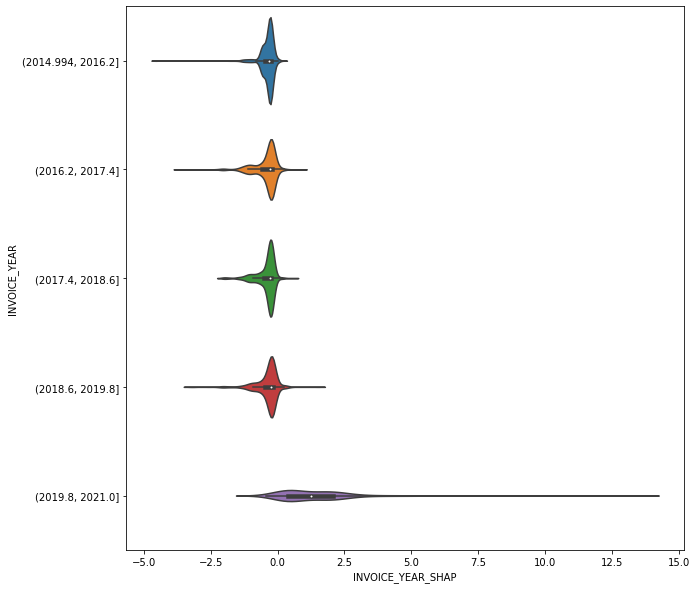

In [275]:
feat = 'INVOICE_YEAR'
feat_shap = [c for c in comb_raw_shap.columns if c == feat + "_SHAP"][0]
binned1 = pd.cut(comb_raw_shap[feat], bins=5)  # need to make a bin because the feature is continuous
data = None
for b in binned1.unique():
    mask = (comb_raw_shap[feat] <= b.right) & (comb_raw_shap[feat] > b.left)
    x = comb_raw_shap[mask][feat_shap].rename(feat_shap)
    y = binned1[mask].rename(feat)
    if data is None:
        data = pd.concat((x, y), axis=1)
    else:
        data = pd.concat((data, pd.concat((x, y), axis=1)), axis=0, ignore_index=True)
        
        
product = 'THB4419Y'
mask_product = comb_raw_shap['COMMERCIAL_NAME'] == product
plt.figure(figsize=(10,10))
ax = sns.violinplot(y=data[feat][mask_product], x=data[feat_shap][mask_product], orient='h')

In [345]:
product = ['AE4425Y','AE4430Y','AE4440Y','AE4440Z','AE4450Y','AE4450Z','AE4456Y','AE4460Y','AE4460Z','AE4470Z',
           'CAJ2428Z','CAJ2432Z','CAJ2446X','CAJ2446Z','CAJ2464U','CAJ2464X','CAJ2464Z','CAJ4461Y','CAJ4476Y',
           'CAJ4492Y','CAJ4511Y','CAJ4517X','CAJ4517Z','CAJ4519T','CAJ4519X','CAJ4519Z','CAJ9480Z','CAJ9510X',
           'CAJ9510Z','CAJ9513X']
def update_output(product):
    if type(product) !=str:
        prod = product[0]
        mask_product = comb_raw_shap['COMMERCIAL_NAME'] == prod
    ax = sns.violinplot(y=data[feat][mask_product], x=data[feat_shap][mask_product], orient='h')
    
    return ax

In [347]:
product = ['AE4425Y','AE4430Y','AE4440Y','AE4440Z','AE4450Y','AE4450Z','AE4456Y','AE4460Y','AE4460Z','AE4470Z',
           'CAJ2428Z','CAJ2432Z','CAJ2446X','CAJ2446Z','CAJ2464U','CAJ2464X','CAJ2464Z','CAJ4461Y','CAJ4476Y',
           'CAJ4492Y','CAJ4511Y','CAJ4517X','CAJ4517Z','CAJ4519T','CAJ4519X','CAJ4519Z','CAJ9480Z','CAJ9510X',
           'CAJ9510Z','CAJ9513X']
def update_output(product):
    if type(product) !=str:
        mask_product = comb_raw_shap['COMMERCIAL_NAME'].isin(product)
    else:
        mask_product = comb_raw_shap['COMMERCIAL_NAME'] == prod
    ax = sns.violinplot(y=data[feat][mask_product], x=data[feat_shap][mask_product], orient='h')
    
    return ax

ValueError: num must be 1 <= num <= 18, not 19

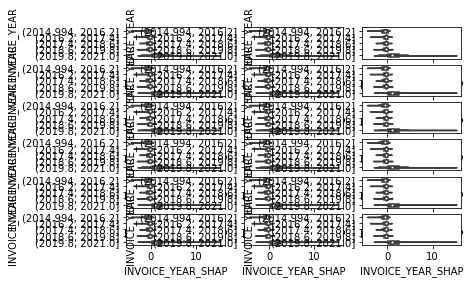

In [356]:
feat = 'INVOICE_YEAR'
feat_shap = [c for c in comb_raw_shap.columns if c == feat + "_SHAP"][0]
binned1 = pd.cut(comb_raw_shap[feat], bins=5)  # need to make a bin because the feature is continuous
data = None
for b in binned1.unique():
    mask = (comb_raw_shap[feat] <= b.right) & (comb_raw_shap[feat] > b.left)
    x = comb_raw_shap[mask][feat_shap].rename(feat_shap)
    y = binned1[mask].rename(feat)
    if data is None:
        data = pd.concat((x, y), axis=1)
    else:
        data = pd.concat((data, pd.concat((x, y), axis=1)), axis=0, ignore_index=True)
product = ['AE4425Y','AE4430Y','AE4440Y','AE4440Z','AE4450Y','AE4450Z','AE4456Y','AE4460Y','AE4460Z','AE4470Z',
           'CAJ2428Z','CAJ2432Z','CAJ2446X','CAJ2446Z','CAJ2464U','CAJ2464X','CAJ2464Z','CAJ4461Y','CAJ4476Y',
           'CAJ4492Y','CAJ4511Y','CAJ4517X','CAJ4517Z','CAJ4519T','CAJ4519X','CAJ4519Z','CAJ9480Z','CAJ9510X',
           'CAJ9510Z','CAJ9513X']
def update_output(product):
    if type(product) !=str:
        mask_product = comb_raw_shap['COMMERCIAL_NAME'].isin(product)
    else:
        mask_product = comb_raw_shap['COMMERCIAL_NAME'] == product
for i in enumerate(product):
    plt.subplot(6,3, i[0]+1)
    ax = sns.violinplot(y=data[feat][mask_product], x=data[feat_shap][mask_product], orient='h')


In [353]:
comb_raw_shap.to_excel('C:/Users/WK615XH/Shap Pred/Top 80 compressor/comb.xlsx')